In [2]:
import pandas as pd

import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

import sys
import os
import nltk

from nltk.corpus import stopwords
import string
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [3]:
pd.set_option('display.max_colwidth', 1000)

**EXTRACTING REVIEWS**

In [13]:
df = pd.read_csv('C:/Users/misha/Desktop/British Airways/BA_reviews.csv')

In [3]:
df1= pd.read_csv('C:/Users/misha/Desktop/British Airways/BA_reviews.csv')

In [ ]:
df.drop(columns=[['Unnamed: 0', 'Unnamed: 3']])

In [22]:
df

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3
0,0,Trip Verified,I will never travel with British Airways aga...,NaN
1,1,✅ Trip Verified,I am already in Portugal so contacted them t...,NaN
2,2,✅ Trip Verified,Terrible. Avoid this airline. It’s now becom...,NaN
3,3,✅ Trip Verified,"Despite being a gold member, the British Air...",NaN
4,4,Not Verified,Regarding the aircraft and seat: The business...,NaN
...,...,...,...,...
995,995,✅ Trip Verified,"Had four flights in total with this airline,...",NaN
996,996,✅ Trip Verified,Johannesburg to Heathrow. British Airways ar...,NaN
997,997,✅ Trip Verified,The queue for bag drop was massive and did n...,NaN
998,998,✅ Trip Verified,British Airways changed plane and consequent...,NaN


**CLEANING TEXT FOR ANALYSIS**


In [14]:
def cleantext(text):
    
    text = re.sub(r'https?:\/\/\S+', '', text) #links
    text = re.sub(r'RT[\s]+', '', text) #removed RT
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removed '#'
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removed mentions
    text = re.sub(r'[^0-9A-Za-z \t]+', '', text) #removed non alphanumeric
    text = text.lower() # convert text to lowercase

    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # other miscellaneous symbols
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    # Remove emojis from the text
    text_without_emojis = emoji_pattern.sub(r'', text)
    return text_without_emojis

In [15]:
df['Reviews'] = df['Reviews'].apply(cleantext)
df['Reviews'] = df['Reviews'].apply(remove_emojis)

In [25]:
df

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3
0,0,Trip Verified,i will never travel with british airways aga...,NaN
1,1,✅ Trip Verified,i am already in portugal so contacted them t...,NaN
2,2,✅ Trip Verified,terrible avoid this airline its now becoming...,NaN
3,3,✅ Trip Verified,despite being a gold member the british airw...,NaN
4,4,Not Verified,regarding the aircraft and seat the business ...,NaN
...,...,...,...,...
995,995,✅ Trip Verified,had four flights in total with this airline ...,NaN
996,996,✅ Trip Verified,johannesburg to heathrow british airways are...,NaN
997,997,✅ Trip Verified,the queue for bag drop was massive and did n...,NaN
998,998,✅ Trip Verified,british airways changed plane and consequent...,NaN


**SENTIMENT ANALYSIS WITH VADER**

In [17]:
def getSentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    compound_score = vs['compound']
    if compound_score >= 0.5:
        return 'Positive'
    elif compound_score < 0 :
        return 'Negative'
    else:
        return 'Neutral'

reviews = df['Reviews']

sentiment_df_vader = pd.DataFrame()

for post in tqdm(reviews):
    sentiment = getSentiment(post)
    row = pd.Series([sentiment, post], index=['Reviews_Sentiment', 'Reviews'])
    sentiment_df_vader = pd.concat([sentiment_df_vader, row.to_frame().T])

sentiment_df_vader.reset_index(drop=True, inplace=True)
sentiment_df_vader = sentiment_df_vader.rename_axis('Tweet_No')
print(sentiment_df_vader.head())
#sentiment_df_vader.to_csv('vader.csv')

100%|██████████| 1000/1000 [00:10<00:00, 93.99it/s]

         Reviews_Sentiment                                            Reviews
Tweet_No                                                                     
0                 Negative    i will never travel with british airways aga...
1                 Negative    i am already in portugal so contacted them t...
2                 Negative    terrible avoid this airline its now becoming...
3                 Negative    despite being a gold member the british airw...
4                 Negative   regarding the aircraft and seat the business ...


**VISUALIZATION**

Pie Chart

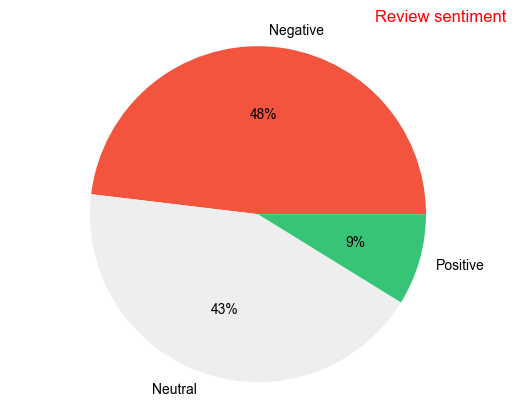

In [18]:
counts = sentiment_df_vader['Reviews_Sentiment'].value_counts() 

color_codes = ["#F2543D", "#EEEEEE", "#38C477"]
sns.set_palette(color_codes)
labels = ['Negative', 'Neutral', 'Positive']
plt.pie(counts, labels=labels, autopct='%.0f%%')
sns.set(font='Calibri')

plt.title('Review sentiment',loc='right',color='red')
plt.axis('equal')
plt.show()

**Word Popularity using N-gram**

tokenizing, removing the stop words, and stemming on previously cleaned texts

In [28]:
pop_list = df.copy()
def remove_punct(text):
    text = "".join([char for char in text if
                    char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = text.strip()  #ADDED
    return text
 
 
pop_list['punct'] = pop_list['Reviews'].apply(
  lambda x: remove_punct(x))
 
# Applying tokenization
def tokenization(text):
    text = re.split('\W+', text)
    text = [t.strip() for t in text] #ADDED
    return text
 
 
pop_list['tokenized'] = pop_list['punct'].apply(
    lambda x: tokenization(x.lower()))
 
# Removing stopwords
#stopword = nltk.corpus.stopwords.words('english')

my_stopwords = ['ukrainian', 'go','president','volodymyr']
stopwords = nltk.corpus.stopwords.words('english')
final_sw = my_stopwords + stopwords
#stopwords.extend(my_stopwords)
def remove_stopwords(text):
    text = [word for word in text if
            word not in final_sw]
    return text
 
pop_list['nonstop'] = pop_list['tokenized'].apply(
  lambda x: remove_stopwords(x))
 
# Applying Stemmer
ps = nltk.PorterStemmer() 
 
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
 
pop_list['stemmed'] = pop_list['nonstop'].apply(
  lambda x: stemming(x))
 
pop_list.head()

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3,punct,tokenized,nonstop,stemmed
0,0,Trip Verified,i will never travel with british airways aga...,NaN,i will never travel with british airways again...,"[i, will, never, travel, with, british, airway...","[never, travel, british, airways, spent, busin...","[never, travel, british, airway, spent, busi, ..."
1,1,✅ Trip Verified,i am already in portugal so contacted them t...,NaN,i am already in portugal so contacted them tod...,"[i, am, already, in, portugal, so, contacted, ...","[already, portugal, contacted, today, cancelle...","[alreadi, portug, contact, today, cancel, retu..."
2,2,✅ Trip Verified,terrible avoid this airline its now becoming...,NaN,terrible avoid this airline its now becoming r...,"[terrible, avoid, this, airline, its, now, bec...","[terrible, avoid, airline, becoming, regular, ...","[terribl, avoid, airlin, becom, regular, pract..."
3,3,✅ Trip Verified,despite being a gold member the british airw...,NaN,despite being a gold member the british airway...,"[despite, being, a, gold, member, the, british...","[despite, gold, member, british, airways, staf...","[despit, gold, member, british, airway, staff,..."
4,4,Not Verified,regarding the aircraft and seat the business ...,NaN,regarding the aircraft and seat the business c...,"[regarding, the, aircraft, and, seat, the, bus...","[regarding, aircraft, seat, business, class, s...","[regard, aircraft, seat, busi, class, seat, fl..."


**Most used words**

In [29]:
def cleantext(text):
    text = remove_punct(text)
    text = tokenization(text.lower())
    text = remove_stopwords(text)
    text = stemming(text) 
    return text

In [30]:
# Applying Countvectorizer
countVectorizer = CountVectorizer(analyzer=cleantext)
countVector = countVectorizer.fit_transform(pop_list['Reviews'])
count_vect_df = pd.DataFrame(
    countVector.toarray(),
  columns=countVectorizer.get_feature_names_out())
count_vect_df.head()
 
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,
                            ascending=False).head(20)
countdf = countdf.rename(columns={0: 'Word Count'})
countdf[0:16]



,Word Count
flight,2009
ba,1177
seat,1043
servic,762
london,632
time,601
hour,518
crew,493
food,488
good,451


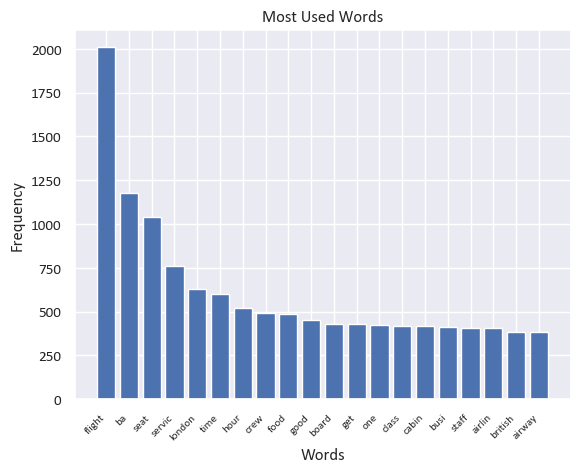

<Figure size 800x600 with 0 Axes>

In [31]:
plt.bar(countdf.index, countdf['Word Count'])

plt.title("Most Used Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.figure(figsize=(8, 6))

plt.show()

**Bigram and Trigram**

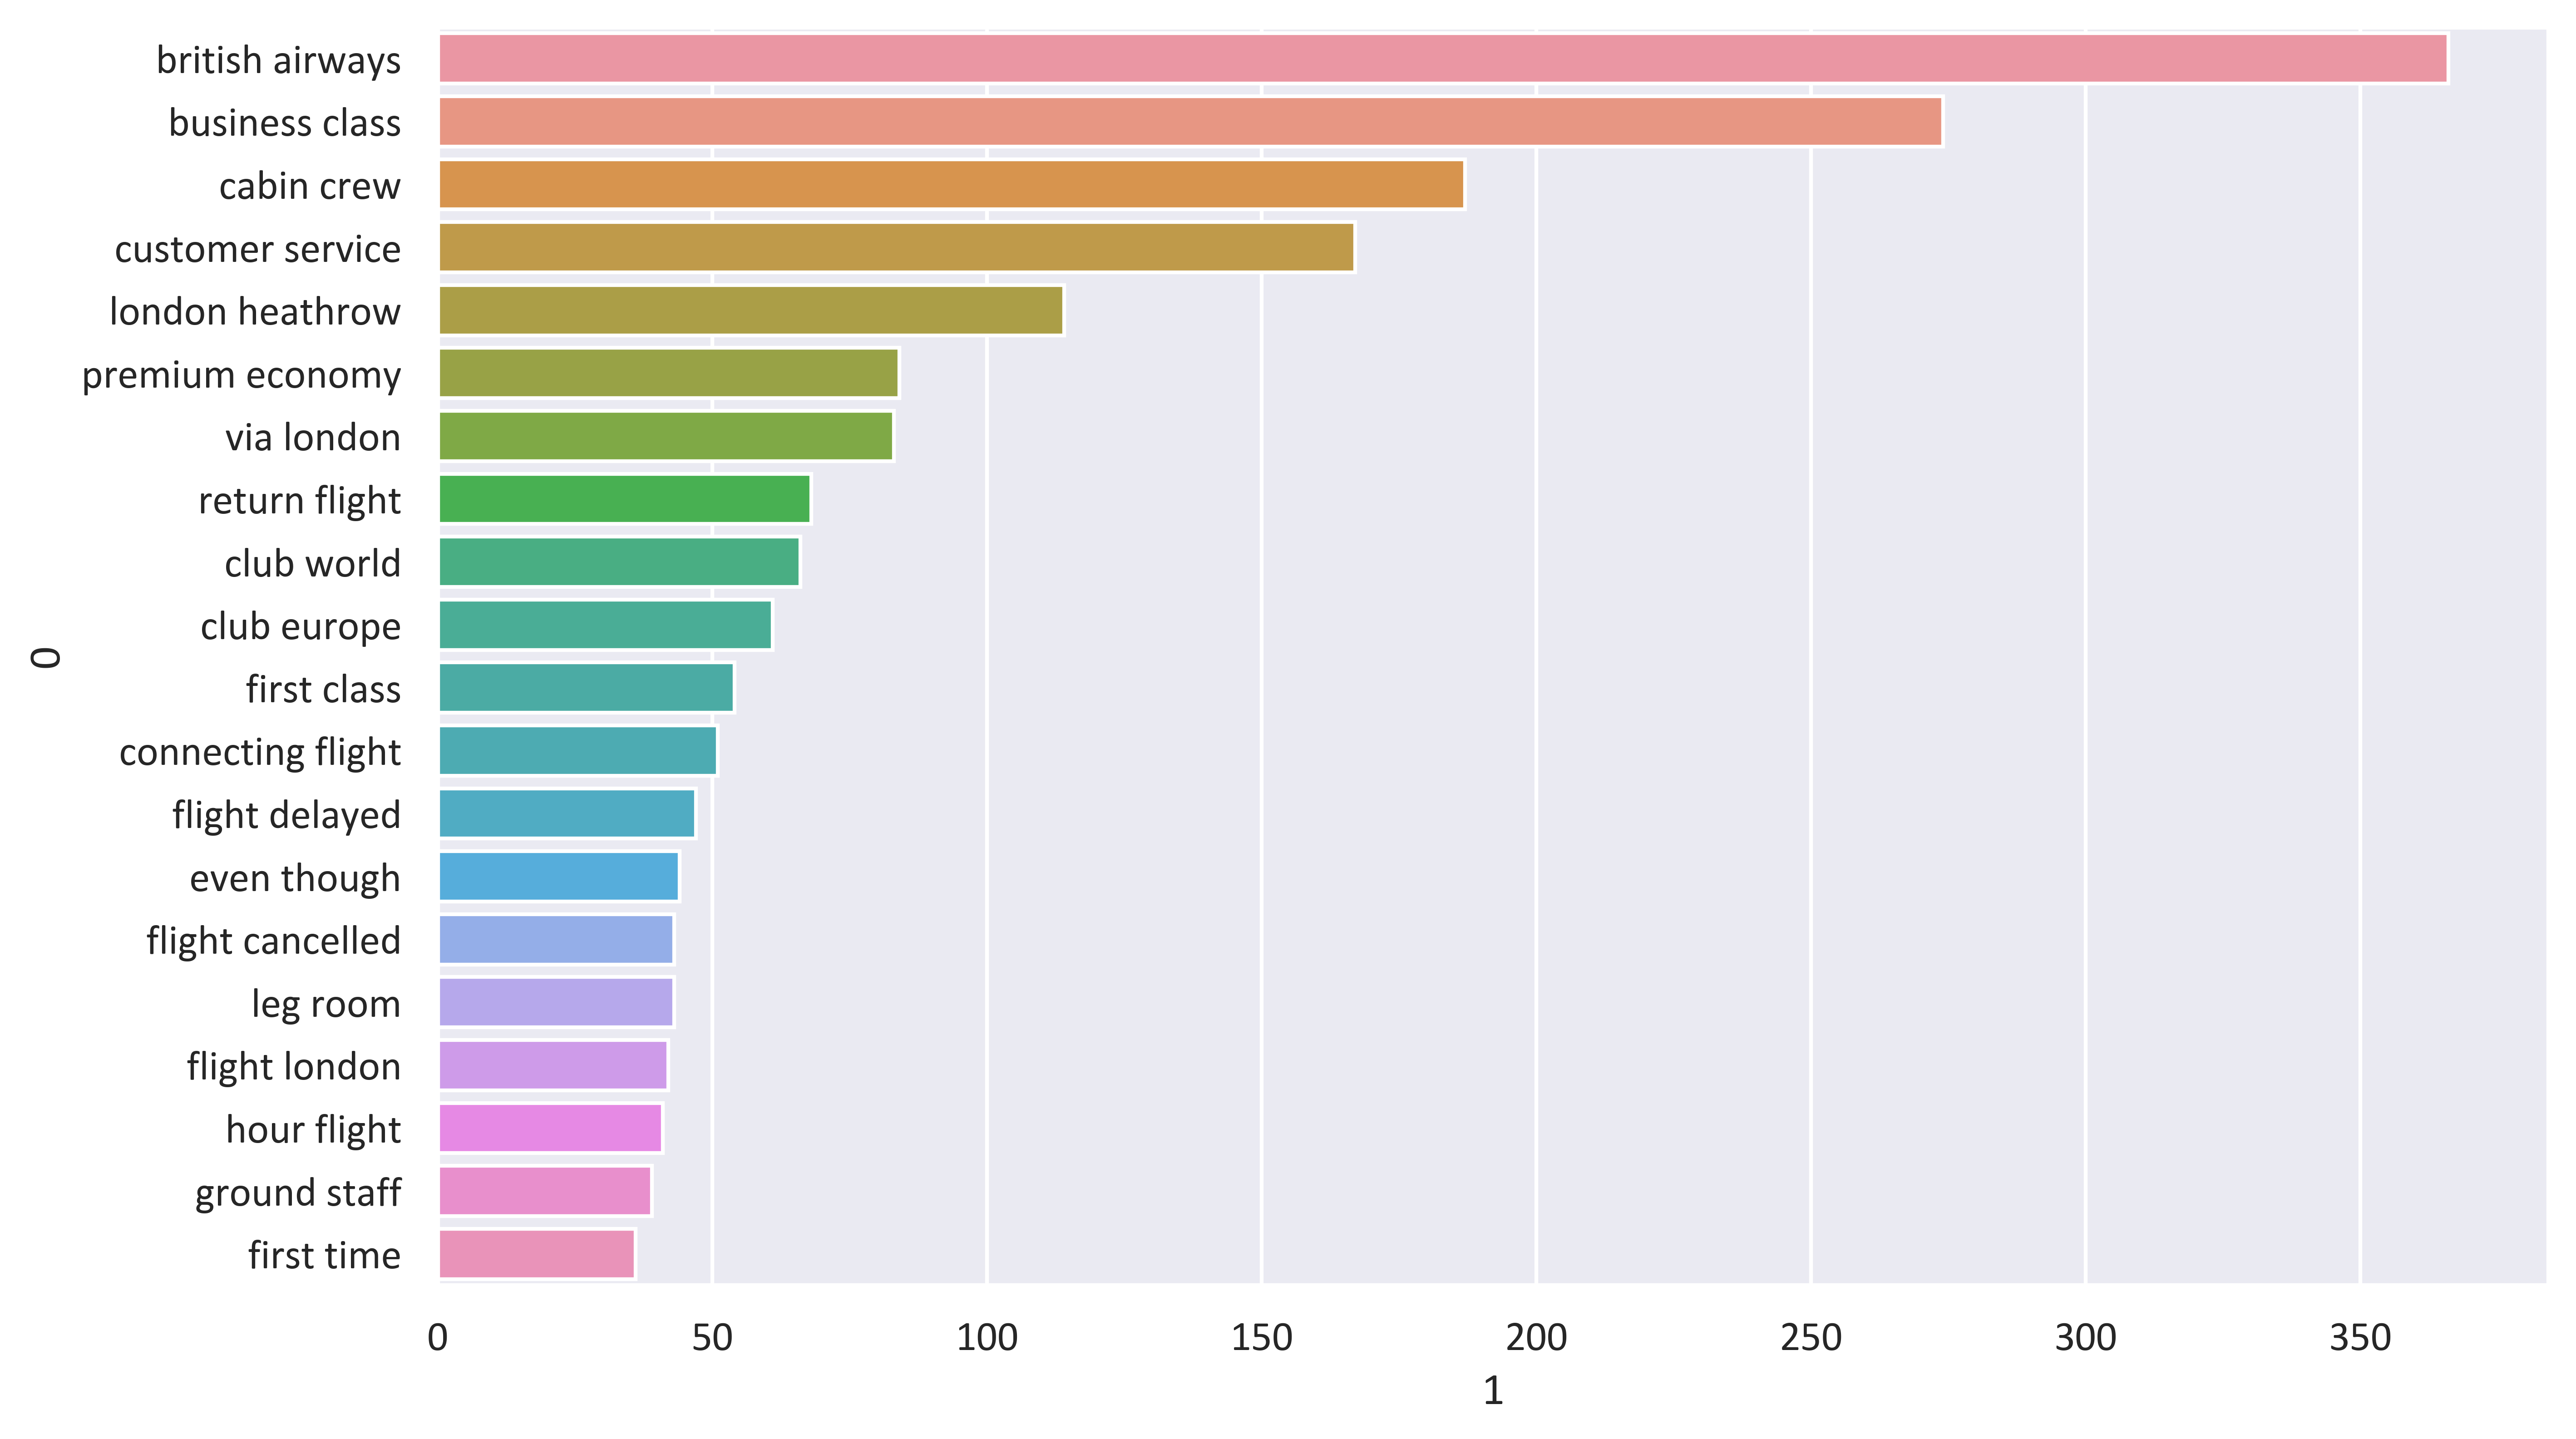

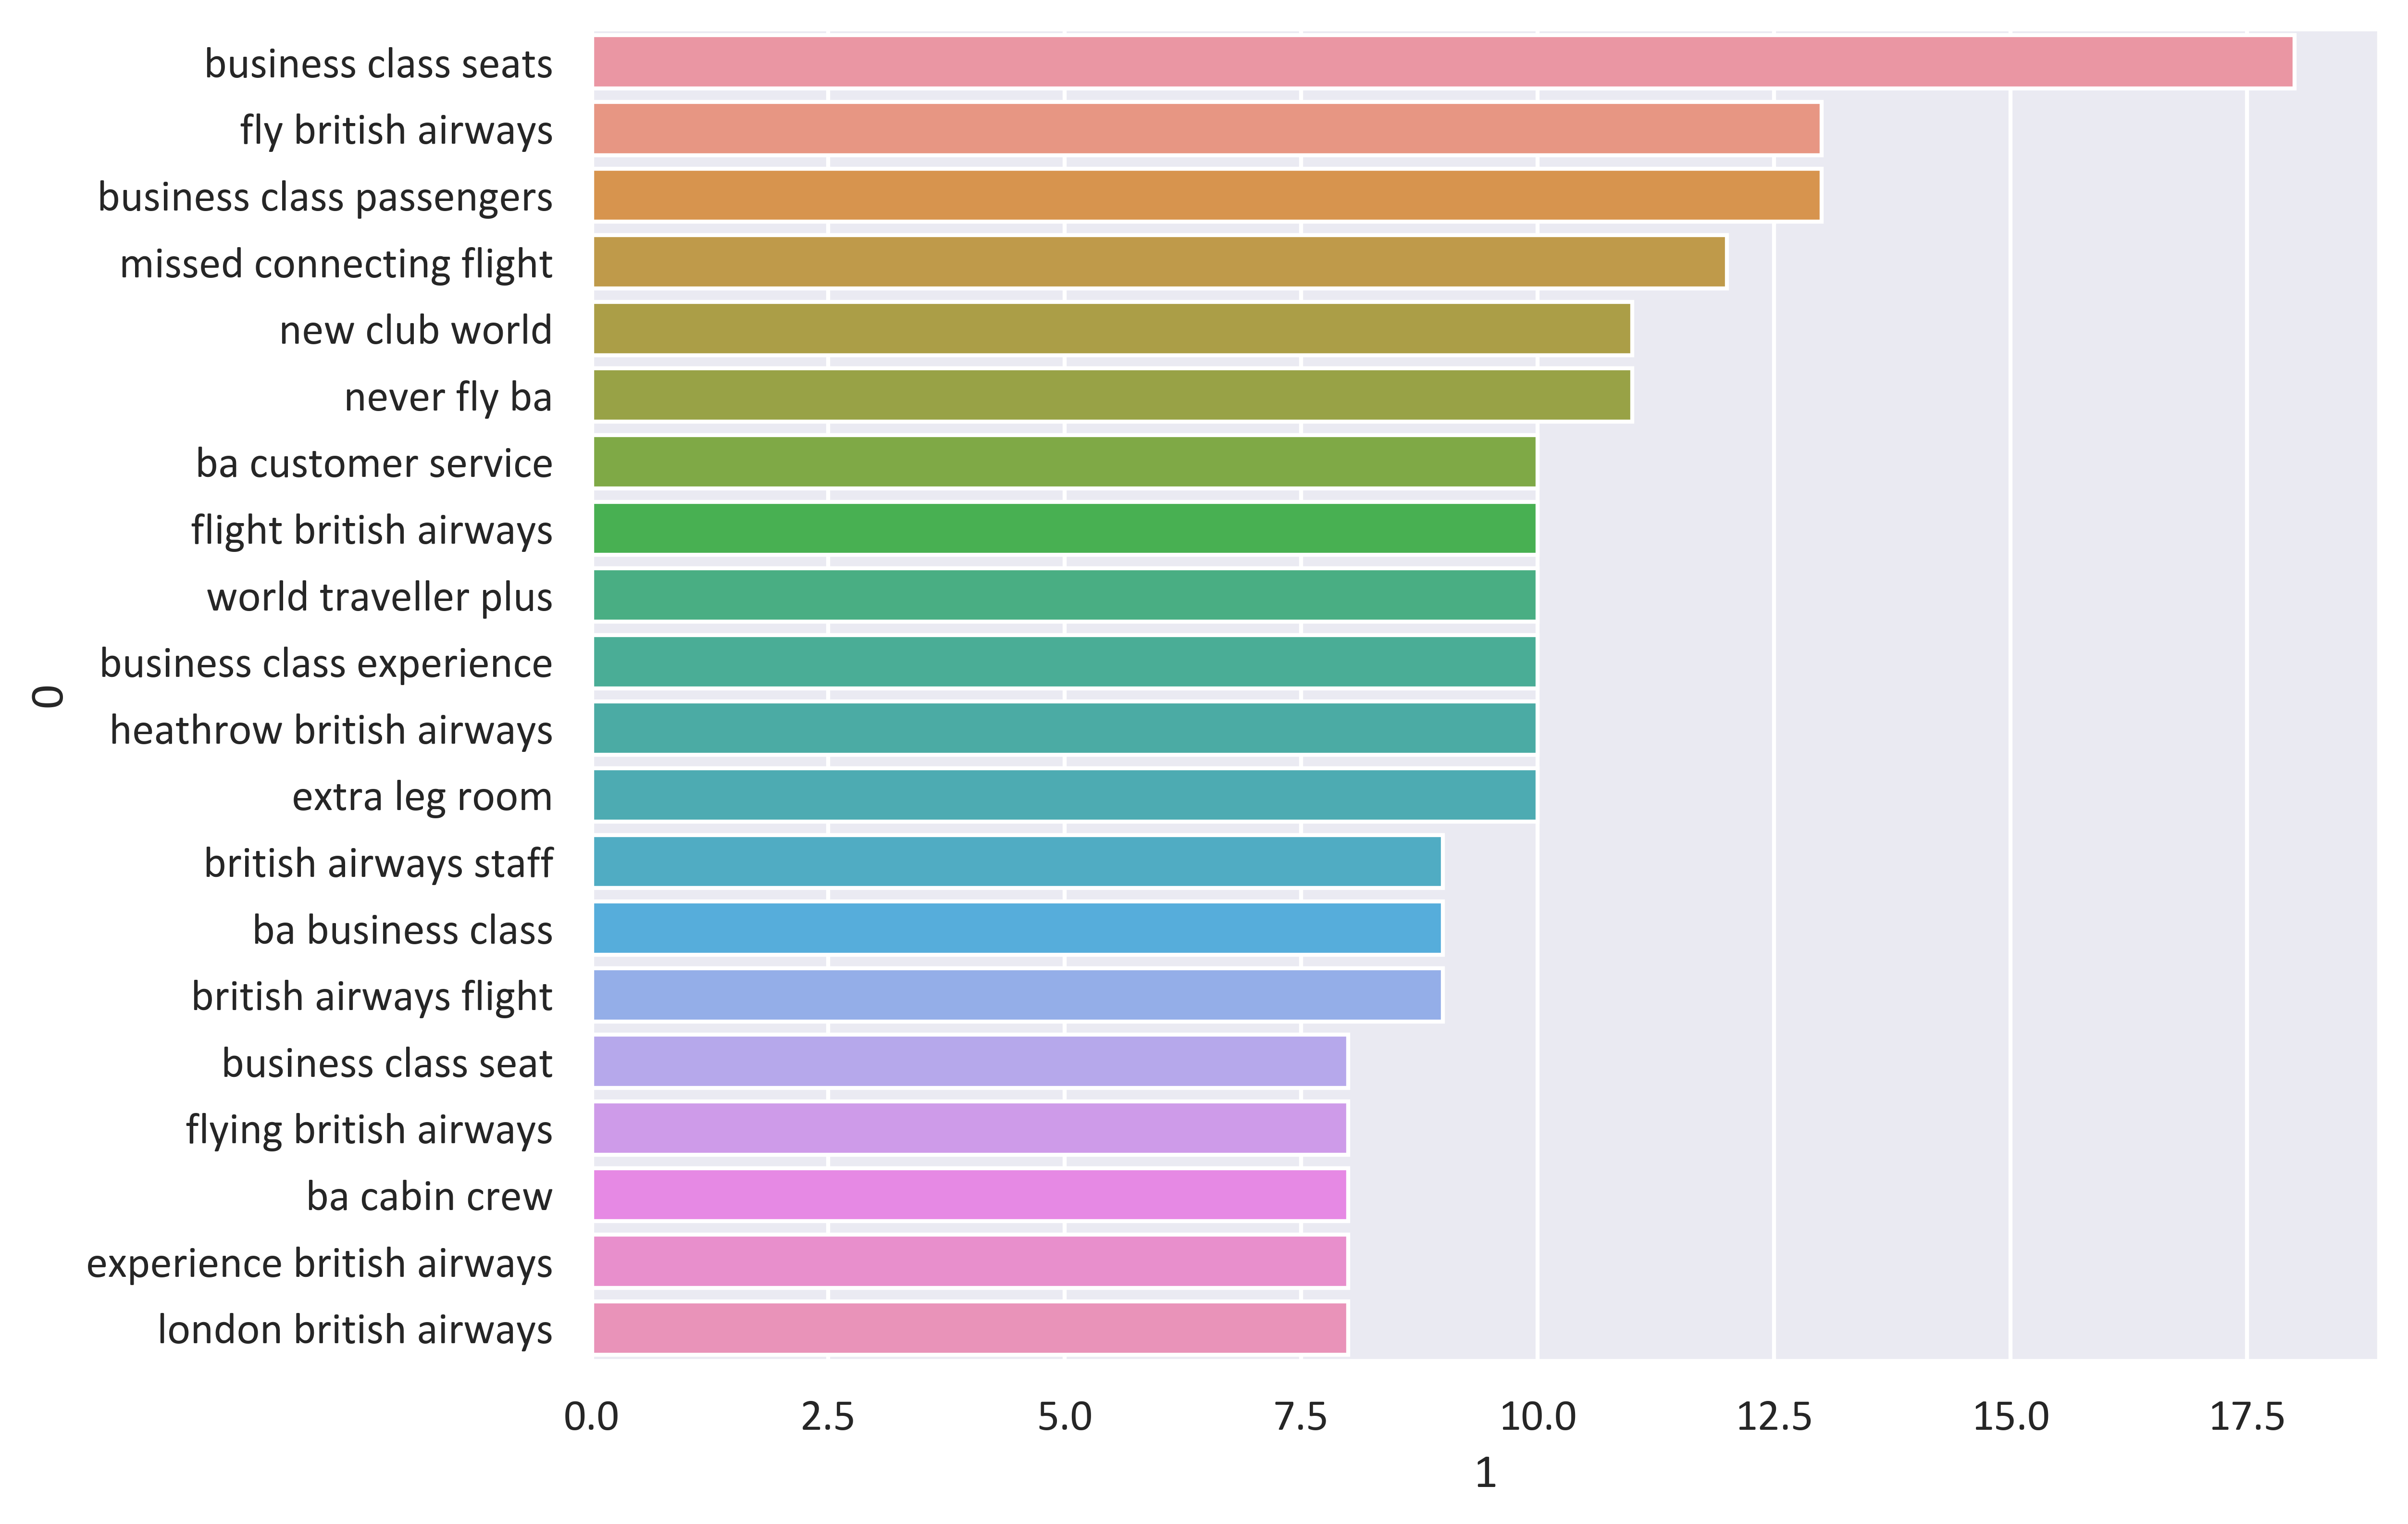

In [32]:
def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range,
                          stop_words=final_sw).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
 
# n2_bigram
n2_bigrams = get_top_n_gram(pop_list['Reviews'], (2, 2), 20)
plt.figure(figsize=(10, 6),
           dpi=600)  # Push new figure on stack
sns_plot = sns.barplot(x=1, y=0, data=pd.DataFrame(n2_bigrams))
#plt.savefig('bigram.jpg')  # Save that figure
# n3_trigram
n3_trigrams = get_top_n_gram(pop_list['Reviews'], (3, 3), 20)
 
plt.figure(figsize=(8, 6),
           dpi=600)  # Push new figure on stack
sns_plot = sns.barplot(x=1, y=0, data=pd.DataFrame(n3_trigrams))
#plt.savefig('trigram.jpg')  # Save that figure

In [5]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
df1['Cleaned Reviews'] = df1['Reviews'].apply(clean)
df1.head()

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3,Cleaned Reviews
0,0,Trip Verified,I will never travel with British Airways aga...,NaN,I will never travel with British Airways agai...
1,1,✅ Trip Verified,I am already in Portugal so contacted them t...,NaN,I am already in Portugal so contacted them to...
2,2,✅ Trip Verified,Terrible. Avoid this airline. It’s now becom...,NaN,Terrible Avoid this airline It s now becoming...
3,3,✅ Trip Verified,"Despite being a gold member, the British Air...",NaN,Despite being a gold member the British Airwa...
4,4,Not Verified,Regarding the aircraft and seat: The business...,NaN,Regarding the aircraft and seat The business ...


In [6]:
import nltk

"""This punkt tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, 
collocations, and words that start sentences. """

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
          #print(tag[0])
          #print(pos_dict.get(tag[0]))
    return newlist 

df1['POS tagged'] = df1['Cleaned Reviews'].apply(token_stop_pos)
df1.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Unnamed: 0,Trip verification,Reviews,Unnamed: 3,Cleaned Reviews,POS tagged
0,0,Trip Verified,I will never travel with British Airways aga...,NaN,I will never travel with British Airways agai...,"[(never, r), (travel, v), (British, a), (Airwa..."
1,1,✅ Trip Verified,I am already in Portugal so contacted them t...,NaN,I am already in Portugal so contacted them to...,"[(already, r), (Portugal, n), (contacted, v), ..."
2,2,✅ Trip Verified,Terrible. Avoid this airline. It’s now becom...,NaN,Terrible Avoid this airline It s now becoming...,"[(Terrible, a), (Avoid, n), (airline, n), (bec..."
3,3,✅ Trip Verified,"Despite being a gold member, the British Air...",NaN,Despite being a gold member the British Airwa...,"[(Despite, None), (gold, n), (member, n), (Bri..."
4,4,Not Verified,Regarding the aircraft and seat: The business...,NaN,Regarding the aircraft and seat The business ...,"[(Regarding, v), (aircraft, n), (seat, v), (bu..."


In [8]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df1['Lemma'] = df1['POS tagged'].apply(lemmatize)
df1.head()

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3,Cleaned Reviews,POS tagged,Lemma
0,0,Trip Verified,I will never travel with British Airways aga...,NaN,I will never travel with British Airways agai...,"[(never, r), (travel, v), (British, a), (Airwa...",never travel British Airways spend business ...
1,1,✅ Trip Verified,I am already in Portugal so contacted them t...,NaN,I am already in Portugal so contacted them to...,"[(already, r), (Portugal, n), (contacted, v), ...",already Portugal contact today cancel return...
2,2,✅ Trip Verified,Terrible. Avoid this airline. It’s now becom...,NaN,Terrible Avoid this airline It s now becoming...,"[(Terrible, a), (Avoid, n), (airline, n), (bec...",Terrible Avoid airline become regular practi...
3,3,✅ Trip Verified,"Despite being a gold member, the British Air...",NaN,Despite being a gold member the British Airwa...,"[(Despite, None), (gold, n), (member, n), (Bri...",Despite gold member British Airways staff He...
4,4,Not Verified,Regarding the aircraft and seat: The business...,NaN,Regarding the aircraft and seat The business ...,"[(Regarding, v), (aircraft, n), (seat, v), (bu...",Regarding aircraft seat business class seat ...


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df1['Sentiment'] = df1['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df1['Analysis'] = df1['Sentiment'].apply(vader_analysis)
df1.head()

,Unnamed: 0,Trip verification,Reviews,Unnamed: 3,Cleaned Reviews,POS tagged,Lemma,Sentiment,Analysis
0,0,Trip Verified,I will never travel with British Airways aga...,NaN,I will never travel with British Airways agai...,"[(never, r), (travel, v), (British, a), (Airwa...",never travel British Airways spend business ...,-0.9643,Negative
1,1,✅ Trip Verified,I am already in Portugal so contacted them t...,NaN,I am already in Portugal so contacted them to...,"[(already, r), (Portugal, n), (contacted, v), ...",already Portugal contact today cancel return...,-0.2263,Negative
2,2,✅ Trip Verified,Terrible. Avoid this airline. It’s now becom...,NaN,Terrible Avoid this airline It s now becoming...,"[(Terrible, a), (Avoid, n), (airline, n), (bec...",Terrible Avoid airline become regular practi...,-0.7430,Negative
3,3,✅ Trip Verified,"Despite being a gold member, the British Air...",NaN,Despite being a gold member the British Airwa...,"[(Despite, None), (gold, n), (member, n), (Bri...",Despite gold member British Airways staff He...,0.7951,Positive
4,4,Not Verified,Regarding the aircraft and seat: The business...,NaN,Regarding the aircraft and seat The business ...,"[(Regarding, v), (aircraft, n), (seat, v), (bu...",Regarding aircraft seat business class seat ...,0.8676,Positive


In [10]:
vader_counts = df1['Analysis'].value_counts()
vader_counts

Positive    520
Negative    374
Neutral     106
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x220a0a78280>,
 [Text(-0.06906950569907239, 1.0978294054098232, 'Positive'),
  Text(-0.2935922724192577, -1.0600960228091116, 'Negative'),
  Text(1.2758351325693755, -0.44129889474332934, 'Neutral')],
 [Text(-0.03767427583585766, 0.5988160393144489, '52.0%'),
  Text(-0.1601412395014133, -0.5782341942595154, '37.4%'),
  Text(0.8033036019881252, -0.2778548596532074, '10.6%')])

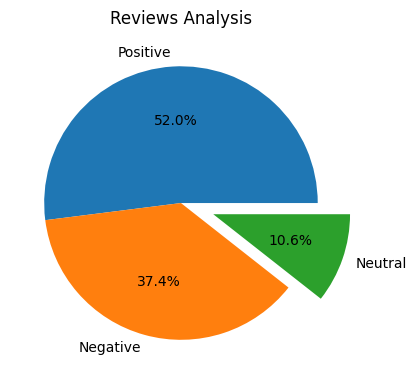

In [11]:
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)